In [19]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# General Setup for the project

In [20]:
# use the dotenv package to load the environment variables
from dotenv import load_dotenv
import os

# load the environment variables from the .env file
load_dotenv()

# get the environment variables and store them in variables
api_key = os.getenv('API_KEY')
base_url = os.getenv('BASE_URL')


# define the start and end date for the historical data
start_date = '2020-01-01'
end_date = '2020-12-31'

In [21]:
## 1 Problem 1: NASA APOD Data Retrieval and JSON File Processing

In [22]:
import requests
from datetime import date , timedelta

def get_apod_data(api_key, date):
    url = f"{base_url}/planetary/apod?api_key={api_key}&date={date}"
    try:
        response = requests.get(url)
        # check if the response is successful and raise an exception incase of an error
        response.raise_for_status()
        # parse the JSON response
        data = response.json()
        return {
            "date": data.get("date"),
            "title": data.get("title"),
            "url": data.get("url"),
            "explanation": data.get("explanation"),
            "media_type": data.get("media_type")
        }
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {date}: {e}")
    except KeyError:
        print("Unexpected response format")

# Get today's date  and fetch the data for today from the API to test the function
today = date.today()
today_data = get_apod_data(api_key, today)

print(today_data)

{'date': '2024-12-08', 'title': "Aurora around Saturn's North Pole", 'url': 'https://apod.nasa.gov/apod/image/2412/SaturnAurora_Hubble_960.jpg', 'explanation': "Are Saturn's auroras like Earth's?  To help answer this question, the Hubble Space Telescope and the Cassini spacecraft monitored Saturn's North Pole simultaneously during Cassini's final orbits around the gas giant in September 2017.  During this time, Saturn's tilt caused its North Pole to be clearly visible from Earth. The featured image is a composite of ultraviolet images of auroras and optical images of Saturn's clouds and rings, all taken by Hubble.  Like on Earth, Saturn's northern auroras can make total or partial rings around the pole. Unlike on Earth, however, Saturn's auroras are frequently spirals -- and more likely to peak in brightness just before midnight and dawn.  In contrast to Jupiter's auroras, Saturn's auroras appear better related to connecting Saturn's internal magnetic field to the nearby, variable, sol

In [23]:
# validate the response data by checking if the response is a dictionary and contains the expected keys and values 
import unittest

class TestGetApodData(unittest.TestCase):
    def test_get_apod_data(self):
        data = get_apod_data(api_key, date.today())
        self.assertIsInstance(data, dict)
        self.assertIn("date", data)
        self.assertIn("title", data)
        self.assertIn("url", data)
        self.assertIn("explanation", data)
        self.assertIn("media_type", data)
    
# Run the test
unittest.main(argv=[''], exit=False)


.
----------------------------------------------------------------------
Ran 1 test in 0.762s

OK


In [24]:
from datetime import datetime
import time

# Function to fetch APOD data for multiple dates within a range
def fetch_multiple_apod_data(api_key, start_date, end_date):
    current_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    
    apod_data = []

    while current_date <= end_date:
        date_str = current_date.strftime("%Y-%m-%d")
        # Fetch data for the current date
        data = get_apod_data(api_key, date_str)
        if data:
            print(f"Fetched data for {date_str}")
            apod_data.append(data)
        # Move to the next date
        current_date += timedelta(days=1)
        # Delay to respect API rate limits
        time.sleep(1)  

    return apod_data

# apod_data = fetch_multiple_apod_data(api_key, start_date, end_date)

In [25]:
# Better approach the fetch the data for multiple dates using start_date and end_date as query parameters in the API URL

def get_range_apod_data(api_key, start_date , end_date):
    url = f"{base_url}/planetary/apod?api_key={api_key}&start_date={start_date}&end_date={end_date}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        formatted_data = []
        for item in data:
            formatted_data.append({
                "date": item.get("date"),
                "title": item.get("title"),
                "url": item.get("url"),
                "explanation": item.get("explanation"),
                "media_type": item.get("media_type")
            })
        return formatted_data
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for the range {start_date} to {end_date}: {e}")
    except KeyError:
        print("Unexpected response format")

In [26]:
import os
import json

def save_to_json(data, filename='apod_data.json'):
    try:
        # Verify if the data is a JSON-serializable list
        if not isinstance(data, list):
            raise ValueError("Data should be a list")

        # Check if the file exists
        if not os.path.exists(filename):
            # If the file does not exist, create it and add the data
            with open(filename, 'w') as file:
                json.dump(data, file, indent=4)
                file.write("\n")
            return
        
        # If the file exists, check if it contains any data
        with open(filename, 'r+') as file:
            if os.stat(filename).st_size == 0:
                # If the file is empty, add the data directly
                json.dump(data, file, indent=4)
                file.write("\n")
            else:
                # If the file has data, load existing data, concatenate with new data
                file.seek(0)
                existing_data = json.load(file)
                
                # Ensure existing data is a list
                if not isinstance(existing_data, list):
                    raise ValueError("Existing file data is not in list format")

                # Concatenate existing data with the new data
                updated_data = existing_data + data
                
                # Write the concatenated data back to the file
                file.seek(0)
                file.truncate(0)
                json.dump(updated_data, file, indent=4)
                file.write("\n")
                
    except ValueError as ve:
        print(f"Data validation error: {ve}")
    except IOError as e:
        print(f"Error writing to file {filename}: {e}")
    except json.JSONDecodeError:
        print(f"Error decoding JSON from file {filename}. Ensure the file format is correct.")


In [27]:
def fetch_and_save_apod_data(api_key, start_date, end_date):
    # using the get_range_apod_data function for better performance and to avoid rate limits
    range_data = get_range_apod_data(api_key, start_date, end_date)
    # to test the loop function, uncomment the line below and comment the line above
    # range_data = fetch_multiple_apod_data(api_key, start_date, end_date)
    if range_data:
        print(f"Fetched data for {len(range_data)} dates")
        # Save the data to a JSON file with the default filename
        save_to_json(range_data) 


fetch_and_save_apod_data(api_key, start_date, end_date)

Fetched data for 365 dates


In [ ]:
## 2 Problem 2: JSON Data Reading,Looping,and Processing

In [28]:
def read_apod_data(filename='apod_data.json'):
    try:
        with open(filename, 'r') as file:
            data = json.load(file)
        for entry in data:
            print(f"Date: {entry['date']}, Title: {entry['title']}")
        return data
    except FileNotFoundError:
        print(f"Error: The file {filename} was not found.")
    except PermissionError:
        print(f"Error: Permission denied when accessing {filename}.")
    except json.JSONDecodeError:
        print(f"Error: The file {filename} is empty or contains invalid JSON.")
    return None

# Read the data from the JSON file
saved_data = read_apod_data()

Date: 2020-01-01, Title: Betelgeuse Imagined
Date: 2020-01-02, Title: The Fainting of Betelgeuse
Date: 2020-01-03, Title: Quadrantids over the Great Wall
Date: 2020-01-04, Title: Aurora Slathers Up the Sky
Date: 2020-01-05, Title: A Starry Night of Iceland
Date: 2020-01-06, Title: Tumultuous Clouds of Jupiter
Date: 2020-01-07, Title: IC 405: The Flaming Star Nebula
Date: 2020-01-08, Title: Galaxies in the River
Date: 2020-01-09, Title: Perihelion to Aphelion
Date: 2020-01-10, Title: Nacreous Clouds over Sweden
Date: 2020-01-11, Title: NGC 602 and Beyond
Date: 2020-01-12, Title: Stars and Dust in Corona Australis
Date: 2020-01-13, Title: A Desert Eclipse
Date: 2020-01-14, Title: Evidence of an Active Volcano on Venus
Date: 2020-01-15, Title: Iridescent Clouds over Sweden
Date: 2020-01-16, Title: NGC 247 and Friends
Date: 2020-01-17, Title: Apollo 17: A Stereo View from Lunar Orbit
Date: 2020-01-18, Title: An Almost Eclipse of the Moon
Date: 2020-01-19, Title: M1: The Incredible Expandin

In [29]:
def analyze_apod_media(data):
    images = 0
    videos = 0 
    detail_explanation = {"date": None , "length": 0}
    for record in data:
        if record['media_type'] == 'image':
            images += 1
        elif record['media_type'] == 'video':
            videos += 1
        
        explanation_length = len(record.get("explanation", ""))
        if explanation_length > detail_explanation['length']:
            detail_explanation['date'] = record['date']
            detail_explanation['length'] = explanation_length

    print(f"Number of images: {images}")
    print(f"Number of videos: {videos}")
    print(f"Date with the longest explanation: {detail_explanation['date']} (Length: {detail_explanation['length']} characters)")


analyze_apod_media(saved_data)

Number of images: 1316
Number of videos: 144
Date with the longest explanation: 2020-08-31 (Length: 1572 characters)


In [30]:
# Extract data into csv file
import csv

def write_to_csv(data, filename='apod_summary.csv'):
    try:
        with open(filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            # Write headers if the file is empty
            if csvfile.tell() == 0:
                writer.writerow(["date", "title", "media_type", "url"])

            # Write data entries
            for entry in data:
                writer.writerow([
                    entry.get("date", ""),
                    entry.get("title", ""),
                    entry.get("media_type", ""),
                    entry.get("url", "")
                ])
        print(f"Data successfully written to {filename}")
    except IOError as e:
        print(f"Error writing to CSV file {filename}: {e}")


if saved_data:
    write_to_csv(saved_data)

Data successfully written to apod_summary.csv


In [ ]:
## Problem3- Numpy Array Manipulation and Statistical Functions

In [31]:
import numpy as np

def create_array(rows=20, cols=5):
    main_array = np.empty((0, 5), dtype=int) 
    while main_array.shape[0] < rows:

        # Generate a random row
        new_row = np.random.randint(10, 100, size=(1, cols))
        
        # Condition 1: Check if the sum of the row is even
        if new_row.sum() % 2 == 0:

            temp_array = np.vstack([main_array, new_row])

            # Condition 2: Check if the sum of all values in the array is a multiple of 5
            if temp_array.sum() % 5 == 0:
                # If both conditions are met, update the main array
                main_array =temp_array

    return main_array


array = create_array()
print(array)

[[45 28 41 42 94]
 [97 32 16 98 37]
 [99 84 87 77 43]
 [38 32 37 63 60]
 [61 33 21 84 41]
 [26 38 39 74 13]
 [50 67 45 19 89]
 [24 10 30 52 44]
 [86 91 18 85 20]
 [13 35 79 90 73]
 [34 11 36 61 18]
 [47 39 69 25 30]
 [24 81 30 49 26]
 [37 20 46 73 14]
 [58 31 87 44 40]
 [74 23 88 34 71]
 [86 93 26 11 84]
 [29 85 40 39 87]
 [72 90 70 29 49]
 [96 28 40 25 61]]


In [32]:
def process_array(array):
    # Elements divisible by both 3 and 5
    divisible_by_3_and_5 = array[(array % 3 == 0) & (array % 5 == 0)]
    print("Elements divisible by both 3 and 5:", divisible_by_3_and_5)

    # Replace elements > 75 with the array mean
    mean_value = array.mean()
    print("Mean value:", mean_value)
    array[array > 75] = mean_value
    print("Modified Array:\n", array)

process_array(array)

Elements divisible by both 3 and 5: [45 60 45 30 90 30 30 90]
Mean value: 50.6
Modified Array:
 [[45 28 41 42 50]
 [50 32 16 50 37]
 [50 50 50 50 43]
 [38 32 37 63 60]
 [61 33 21 50 41]
 [26 38 39 74 13]
 [50 67 45 19 50]
 [24 10 30 52 44]
 [50 50 18 50 20]
 [13 35 50 50 73]
 [34 11 36 61 18]
 [47 39 69 25 30]
 [24 50 30 49 26]
 [37 20 46 73 14]
 [58 31 50 44 40]
 [74 23 50 34 71]
 [50 50 26 11 50]
 [29 50 40 39 50]
 [72 50 70 29 49]
 [50 28 40 25 61]]


In [33]:
# Statistical Operations
mean = array.mean()
std_dev = array.std()
median = np.median(array)
column_variance = array.var(axis=0)

print(f"Mean of array: {mean}")
print(f"Standard deviation of array: {std_dev}")
print(f"Median of array: {median}")
print(f"Variance of each column: {column_variance}")


Mean of array: 41.43
Standard deviation of array: 15.88852101361231
Median of array: 42.5
Variance of each column: [244.49   203.4275 202.26   272.25   295.6   ]


In [ ]:
# Problem 4 -Working with Pandas Data Frames

In [34]:
import pandas as pd

# Load the dataset
df = pd.read_csv('iris.csv')

population = len(df)
# give the column names as its missing in the dataset
columns = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
df.columns = columns
column_names = df.columns.tolist()
data_types = df.dtypes
unique_species = df['Species'].nunique()

print(f"Number of data points: {population}")
print(f"Data types:\n{data_types}")
print(f"Column names: {column_names}")
print(f"Number of unique species: {unique_species}")


Number of data points: 149
Data types:
SepalLength    float64
SepalWidth     float64
PetalLength    float64
PetalWidth     float64
Species         object
dtype: object
Column names: ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
Number of unique species: 3


In [35]:
# Correct the errors in the dataset
df.loc[34] = [4.9, 3.1, 1.5, 0.2, "setosa"] 
df.loc[37] = [4.9, 3.6, 1.4, 0.1, "setosa"]

corrected_rows = df.loc[[34, 37]]

print("Corrected rows:")
print(corrected_rows)


Corrected rows:
    SepalLength  SepalWidth  PetalLength  PetalWidth Species
34          4.9         3.1          1.5         0.2  setosa
37          4.9         3.6          1.4         0.1  setosa


In [36]:
# Add new features
df['PetalRatio'] = df['PetalLength'] / df['PetalWidth']
df['SepalRatio'] = df['SepalLength'] / df['SepalWidth']

# Save the modified DataFrame to a new CSV file
df.to_csv('iris_corrected.csv', index=False)

print("New features added and the modified dataset saved as 'iris_corrected.csv'.")


New features added and the modified dataset saved as 'iris_corrected.csv'.


In [37]:
# Calculate pairwise correlations excluding the 'Species' column
correlation_m = df[['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'PetalRatio', 'SepalRatio']].corr()

# Identify the highest positive and negative correlations
h_positive = correlation_m.unstack().sort_values(ascending=False).head(1)
h_negative = correlation_m.unstack().sort_values().head(1)

hp_pair = h_positive.index[0]
hn_pair = h_negative.index[0]


print({
    "Highest Positive Correlation": {
        "Pair": hp_pair,
        "value": h_positive.values[0]
    },
    "Highest Negative Correlation": {
        "Pair": hn_pair,
        "value": h_negative.values[0]
    }
})

{'Highest Positive Correlation': {'Pair': ('SepalLength', 'SepalLength'), 'value': np.float64(1.0)}, 'Highest Negative Correlation': {'Pair': ('SepalWidth', 'SepalRatio'), 'value': np.float64(-0.748292081676566)}}


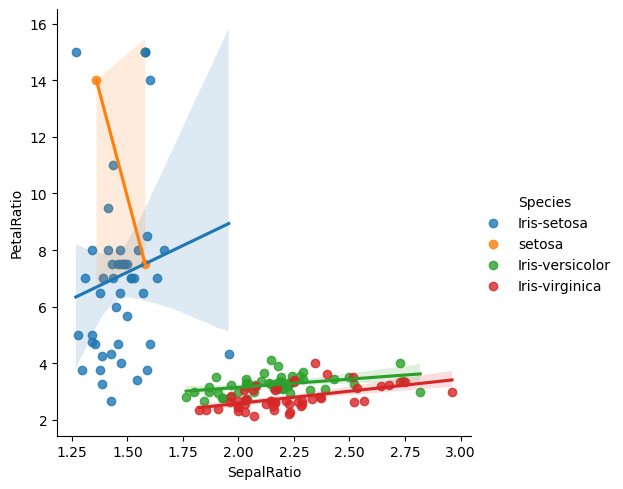

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(x='SepalRatio', y='PetalRatio', data=df, hue='Species', fit_reg=True)
plt.savefig('iris_scatter_with_regression.pdf')
plt.show()

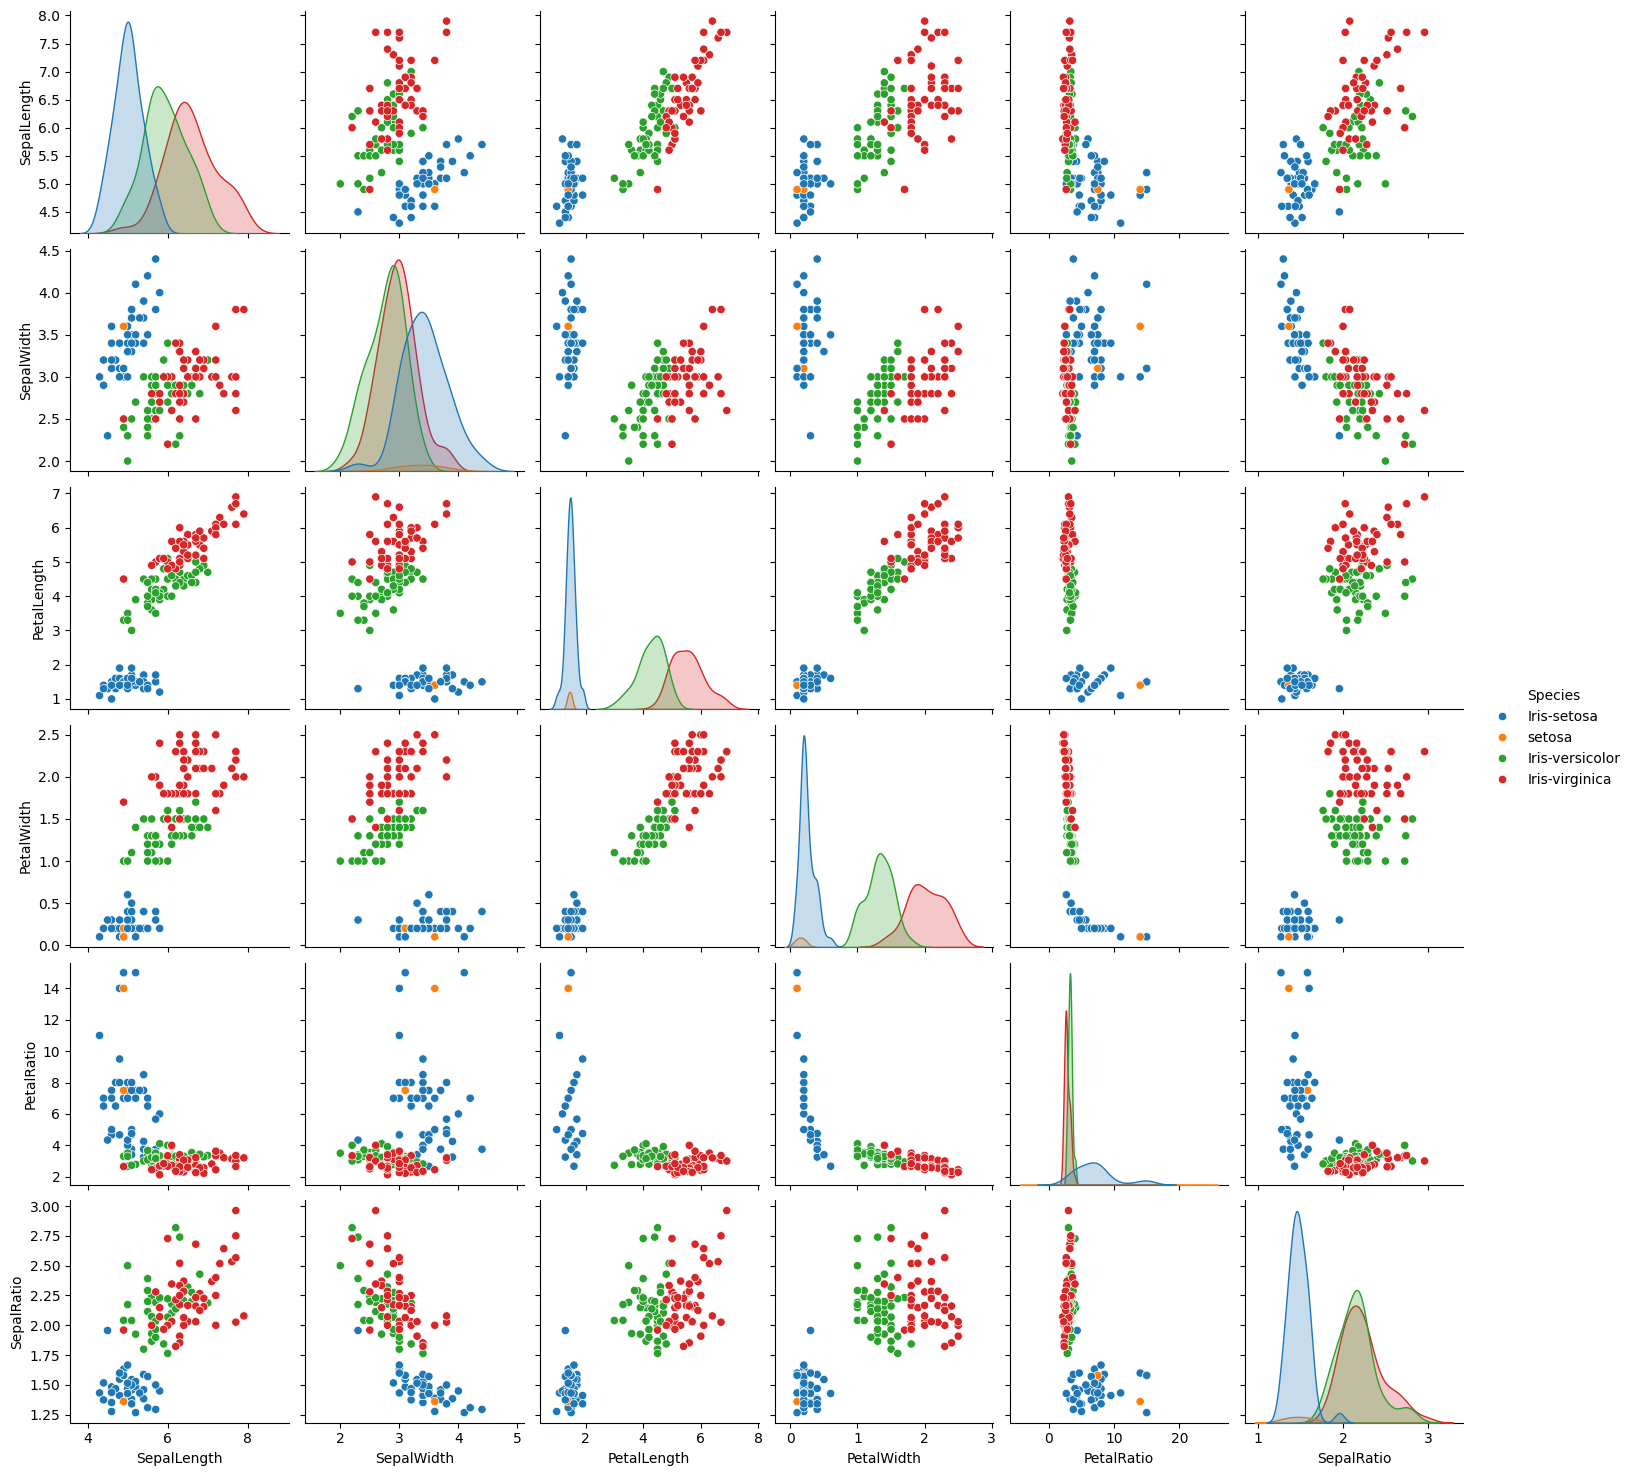

In [40]:
sns.pairplot(df, vars=['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'PetalRatio', 'SepalRatio'], hue='Species')
plt.savefig('iris_pairplot.pdf')
plt.show()